In [19]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import tensorflow as tf

import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


def get_fields(file_location):
    fields = {}
    try:
        for summary in summary_iterator(file_location):
            for v in summary.summary.value:
                if v.tag not in fields:
                    fields[v.tag] = []
                fields[v.tag].append(v.simple_value)
    except:
        return fields
    return fields


def moving_average_filter(data, span_N):
    data_cpy = data[:]
    for i,d in enumerate(data):
        span_n = span_N
        while (i < span_n or ((len(data)-1)-i) < span_n) and span_n >= 1:
           span_n -= 1
        curr_avrg = d
        for cntr in range(1, (span_n+1)):
            curr_avrg += data[i+cntr]
            curr_avrg += data[i-cntr]
        data_cpy[i] = curr_avrg / (2*span_n + 1)
    return data_cpy

def get_events_paths(base_folder, remove_duplicates = True):
    '''Return dict of {exp_name: event_file_path} '''
    experiments = {}
    tfeventstr = "events.out.tfevents"
    for root, dirs, file in os.walk(base_folder, topdown=False):
        for f in file:
            if tfeventstr in f:
                name = root.split('/')[-1]
                if remove_duplicates and 'N' in name:
                    hldr = name.split('_')[-1]
                    num = int(hldr[1:])
                    if num > 0:
                        continue
                experiments[name] = os.path.join(root, f)
    return experiments
    
def get_event_data(base_folder, remove_duplicates = True):
    '''Return {exp_name: dict_of_fields} '''
    experiments = get_events_paths(base_folder, remove_duplicates)
    for k,v in experiments.items():
        experiments[k] = get_fields(v)
    return experiments


def filter(data, filter_terms):
    filter_data = {}
    for k,v in data.items():
        flag = True
        for term in filter_terms:
            if not term in k:
                flag = False
        if flag:
            filter_data[k] = v
    return filter_data

def plot(ax, data, field, plot_term, smooth = None):
    '''data is already in filtered form
    data: {name:list of data_points} '''
    lookup = set()
    exclude_last_points = 1
    for k, v in data.items():
        if plot_term in k:
            exp_id = k.split("_")
            ind = exp_id.index(plot_term)
            plot_term_value = exp_id[ind+1]
            if not plot_term_value in lookup:
                lookup.add(plot_term_value)
                label = plot_term + ' = ' + plot_term_value
                if not smooth is None:
                    new_data = moving_average_filter(v[field], smooth)
                    exclude_last_points = smooth + 1
                else:
                    new_data = v[field][:]
                x = np.arange(len(new_data))
                ax.plot(x[:-exclude_last_points], new_data[:-exclude_last_points], label = label)

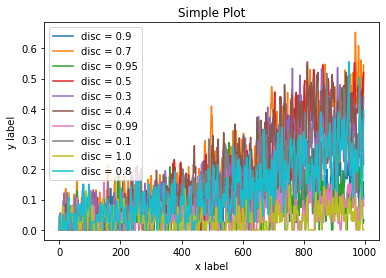

In [22]:
file = '/home/james/Desktop/Gridworld/test/test2'

fig, ax = plt.subplots()

all_data = get_event_data(file)

filter_terms = ["envsize_7"]
field = "agent_dones"
plot_term = "disc"

data = filter(all_data, filter_terms)
plot(ax, data, field, plot_term, smooth=2)

ax.set_xlabel('x label')  # Add an x-label to the axes.
ax.set_ylabel('y label')  # Add a y-label to the axes.
ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend()  # Add a legend.
plt.show()